# 1. IMPORTS

In [1]:
import joblib
import numpy       as np
import pandas      as pd
import spacy
import tensorflow  as tf
import transformer as trfm
from matplotlib                                         import pyplot as plt
from sklearn.decomposition                              import PCA
from sklearn.metrics                                    import accuracy_score, classification_report
from sklearn.model_selection                            import RandomizedSearchCV, train_test_split
from sklearn.preprocessing                              import LabelEncoder
from tensorflow.keras.layers                            import Bidirectional, Dense, Dropout, Embedding, GlobalAveragePooling1D, Input, LSTM, RNN
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.metrics                           import Accuracy, Precision, Recall
from tensorflow.keras.utils                             import to_categorical

In [2]:
pd.set_option("display.max_rows", None)
np.random.seed(43)

# 2. LOAD DATA

In [3]:
df = pd.read_csv("wikipedia_evidence_dataset_29429.csv")
df = df[["Evidence", "Dominant Concept"]]

df.rename(columns = {"Evidence": "sentence", "Dominant Concept": "topic"}, inplace = True)

# 3. DATA EXPLORATION

### Number of words per sentence

In [4]:
df["sentence"].apply(lambda string: len(string.strip().split(" "))).describe()

count    29429.000000
mean        31.635767
std         15.925884
min          1.000000
25%         20.000000
50%         28.000000
75%         39.000000
max        304.000000
Name: sentence, dtype: float64

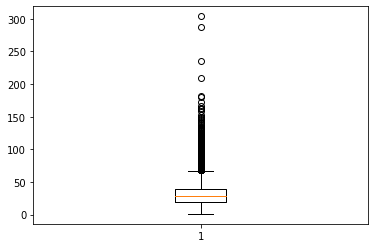

In [5]:
plt.boxplot(df["sentence"].apply(lambda string: len(string.strip().split(" "))))
plt.savefig("./images/boxplot_words.png")
plt.show()

### Class statistics

#### Number of classes

In [6]:
df["topic"].describe()

count              29429
unique               221
top       United Nations
freq                 481
Name: topic, dtype: object

#### Class distribution

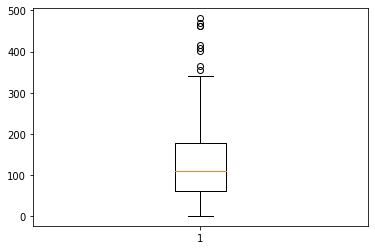

In [7]:
plt.boxplot(df.groupby("topic")["topic"].count())
plt.savefig("./images/boxplot_class.png")
plt.show()

In [8]:
df.groupby("topic")["topic"].count().describe()

count    221.000000
mean     133.162896
std       97.069191
min        1.000000
25%       62.000000
50%      111.000000
75%      177.000000
max      481.000000
Name: topic, dtype: float64

#### Range of word in a sentence: 10 to 40

In [9]:
df.shape

(29429, 2)

In [10]:
df = df[(df["sentence"].apply(lambda string: len(string.strip().split(" "))) <= 50) &
        (df["sentence"].apply(lambda string: len(string.strip().split(" "))) >= 15)]

df.shape

(23395, 2)

#### Minimum examples = 90 and Maximum examples = 300

In [11]:
df = df.join(df.groupby("topic")["topic"].count().where((df.groupby("topic")["topic"].count() >= 90) &
                                                        (df.groupby("topic")["topic"].count() <= 350)).dropna(),
             on = "topic", how = "inner", lsuffix = "", rsuffix = "_drop").drop("topic_drop", axis = 1)

df.shape

(17151, 2)

## Preprocessed dataset

### Words

In [12]:
df["sentence"].apply(lambda string: len(string.strip().split(" "))).describe()

count    17151.000000
mean        29.306280
std          9.372449
min         15.000000
25%         21.000000
50%         28.000000
75%         36.000000
max         50.000000
Name: sentence, dtype: float64

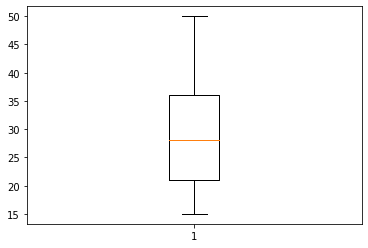

In [13]:
plt.boxplot(df["sentence"].apply(lambda string: len(string.strip().split(" "))))
plt.savefig("./images/boxplot_words_prep.png")
plt.show()

### Class

In [14]:
df["topic"].describe()

count                17151
unique                 109
top       Higher education
freq                   340
Name: topic, dtype: object

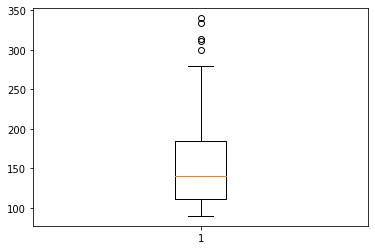

In [15]:
plt.boxplot(df.groupby("topic")["topic"].count())
plt.savefig("./images/boxplot_class_prep.png")
plt.show()

# 4. TRAINING THE MODEL

In [40]:
MAX_SENTENCE_LENGTH = 50
VOCAB_SIZE          = 40000

### Split the dataset into train and test sets

In [17]:
train_set, test_set, train_label, test_label = train_test_split(df.drop("topic", axis = 1), df["topic"],
                                                                test_size = 0.2, random_state = 43, 
                                                                stratify = df["topic"])

### Vectorize the dataset

In [18]:
nlp         = spacy.load('en_core_web_lg')

## Encode the class labels
encoder     = LabelEncoder()
train_label = np.array(train_label)
test_label  = np.array(test_label)
train_label = encoder.fit_transform(train_label)
test_label  = encoder.transform(test_label)

In [19]:
# Vectorizations steps for the neural network
vectorizer = TextVectorization(max_tokens = VOCAB_SIZE, output_sequence_length = MAX_SENTENCE_LENGTH)
text_train = tf.data.Dataset.from_tensor_slices(train_set)

vectorizer.adapt(text_train)

word_index = dict(zip(vectorizer.get_vocabulary(), range(len(vectorizer.get_vocabulary()))))

In [20]:
# Embedding Matrix of words; shape num_words x 300 (dimension of spacy embedding for each word)
embedding_matrix = np.zeros((len(vectorizer.get_vocabulary()) + 2, 300))

for word, i in word_index.items():
    embedding_vector = nlp.vocab.get_vector(word)
    
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [21]:
train_set   = vectorizer(np.array([text["sentence"] for index, text in train_set.iterrows()])).numpy()
test_set    = vectorizer(np.array([text["sentence"] for index, text in test_set.iterrows()])).numpy()
train_label = to_categorical(encoder.fit_transform(np.array(train_label)), num_classes = df["topic"].nunique())
test_label  = to_categorical(encoder.transform(np.array(test_label)), num_classes = df["topic"].nunique())

In [22]:
embedding_layer = Embedding(len(vectorizer.get_vocabulary()) + 2,
                            output_dim = 300,
                            embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
                            trainable              = False)

## Model

### LSTM Bidirectional neural network

In [41]:
inputs             = tf.keras.Input(shape = (MAX_SENTENCE_LENTGH, ), dtype = "int64")
embedded_sequences = embedding_layer(inputs)
x                  = Bidirectional(LSTM(64, return_sequences = True))(embedded_sequences)
x                  = Bidirectional(LSTM(64))(x)
outputs            = Dense(df["topic"].nunique(), activation = "softmax")(x)
model              = tf.keras.Model(inputs, outputs)

model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 300)           9699600   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 128)           186880    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_29 (Dense)             (None, 109)               14061     
Total params: 9,999,357
Trainable params: 299,757
Non-trainable params: 9,699,600
_________________________________________________________________


In [43]:
metrics = [Accuracy(name = "accuracy"), Precision(name = "precision"), Recall(name = "recall")]

model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = [metrics])

In [ ]:
model.fit(train_set, train_label, batch_size = 32, epochs = 50, validation_split = 0.15)

In [ ]:
model.save("model_lstm_bidirectional")

In [ ]:
model_lstm = tf.keras.models.load_model("model_lstm_bidirectional")

### Transformer

In [23]:
embed_dim = 300  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim    = 32  # Hidden layer size in feed forward network inside transformer

In [49]:
inputs              = Input(shape = (MAX_SENTENCE_LENTGH,))
embbeded_layer      = trfm.TokenAndPositionEmbedding(MAX_SENTENCE_LENGTH, len(vectorizer.get_vocabulary()), 300, embedding_layer)
x                   = embbeded_layer(inputs)
transformer_block   = trfm.TransformerBlock(embed_dim, num_heads, ff_dim)
x                   = transformer_block(x)
x                   = GlobalAveragePooling1D()(x)
x                   = Dropout(0.1)(x)
x                   = Dense(20, activation = "relu")(x)
x                   = Dropout(0.1)(x)
outputs             = Dense(df["topic"].nunique(), activation = "softmax")(x)
model               = tf.keras.Model(inputs = inputs, outputs = outputs)

model.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 50)]              0         
_________________________________________________________________
token_and_position_embedding (None, 50, 300)           9714600   
_________________________________________________________________
transformer_block_6 (Transfo (None, 50, 300)           381932    
_________________________________________________________________
global_average_pooling1d_4 ( (None, 300)               0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 20)                6020      
_________________________________________________________________
dropout_23 (Dropout)         (None, 20)              

In [50]:
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = [metrics])

In [ ]:
model.fit(train_set, train_label, batch_size = 32, epochs = 10, validation_split = 0.15)

In [ ]:
model.save("model_bert")

In [ ]:
model_bert = tf.keras.models.load_model("model_bert")

# 5. EVALUATION

In [ ]:
lstm_pred = model_lstm.predict(test_set).argmax(axis = -1)
bert_pred = model_bert.predict(test_set).argmax(axis = -1)

In [ ]:
print("LSTM Biderectional Accuracy: {:.2f}%".format(accuracy_score(test_label, lstm_pred) * 100))
print("BERT Accuracy: {:.2f}%".format(accuracy_score(test_label, bert_pred) * 100))

# 6. RESULTS

## Metrics reports

In [ ]:
test_label = encoder.inverse_transform(test_label)
lstm_pred  = encoder.inverse_transform(lstm_pred)
bert_pred  = encoder.inverse_transform(bert_pred)

In [ ]:
clf_rep_lstm = pd.DataFrame(classification_report(test_label, lstm_pred, output_dict = True)).T
clf_rep_bert = pd.DataFrame(classification_report(test_label, bert_pred, output_dict = True)).T

In [ ]:
print("Classification report for the LSTM Bidirectional Classifier: \n", classification_report(test_label, lstm_pred), "\n")
print("Classification report for the BERT Classifier: \n", classification_report(test_label, bert_pred))